![Correlation Plot](/images/Correlations.svg)

# Uncertainties

Here we discuss the python [uncertainties](https://pythonhosted.org/uncertainties/) package and demonstrate some of its features.
<!-- TEASER_END -->

The primary purpose of the [uncertainties](https://pythonhosted.org/uncertainties/) package is to represent quantities with correlated errors:

In [1]:
import mmf_setup;mmf_setup.nbinit(quiet=True)
import numpy as np
import uncertainties
from uncertainties import ufloat
x = ufloat(1.0, 0.1)
x

<IPython.core.display.Javascript object>

1.0+/-0.1

Here $x$=`x` represents a quantity with nominal value `1.0` and error `0.1` in the sense of one standard deviation.  I.e. we assume that the parameter $x$ represents a normally distributed [random variable](https://en.wikipedia.org/wiki/Random_variable) with a Gaussian probability distribution function (PDF)

$$
  P(x) = \frac{\exp\left(-\frac{(x-\bar{x})^2}{2\sigma^2}\right)}
              {\sqrt{2\pi\sigma^2}}
$$

where $\bar{x} = \braket{x}$ is the mean of the distribution and $\sigma^2$ is the variance.

Base quantities can be combined in such a way that the errors propagate forward using standard error analysis techniques.  This propagation of errors assumes that the errors represent 1 standard deviation of normal Gaussian errors and that the errors are small enough for any functional dependence to be well approximated by a linear relationship.  For example, we can demonstrate the following simple rules for adding uncorrelated errors:

In [2]:
a = ufloat(1.0, 0.1)
b = ufloat(2.0, 0.3)

**Addition**: Absolute errors add in quadrature.

In [3]:
a+b, np.sqrt(a.s**2 + b.s**2)

(3.0+/-0.31622776601683794, 0.31622776601683794)

**Multiplication/Division**: Relative errors add in quadrature.

In [4]:
print(a*b, np.sqrt((a.s/a.n)**2 + (b.s/b.n)**2)*(a*b).n)
print(a/b, np.sqrt((a.s/a.n)**2 + (b.s/b.n)**2)*(a/b).n)

2.0+/-0.4 0.36055512754639896
0.50+/-0.09 0.09013878188659974


**Powers:** Relative errors add in quadrature weighted by factors of the square of the power.

In [5]:
a**2*b**(-3), np.sqrt((2*a.s/a.n)**2 + (3*b.s/b.n)**2)*(a**2/b**3).n

(0.125+/-0.06155536126122565, 0.06155536126122565)

# Correlations

One great feature is the ability to track correlations.  Thus, if we $c=ab$, then the errors in $b$ and $c$ are correlated.

In [6]:
c = a*b
print("cov(a, b, c):\n{}\n".format(np.array(uncertainties.covariance_matrix([a, b, c]))))
print("cov(b, c):\n{}\n".format(np.array(uncertainties.covariance_matrix([b, c]))))

cov(a, b, c):
[[0.01 0.   0.02]
 [0.   0.09 0.09]
 [0.02 0.09 0.13]]

cov(b, c):
[[0.09 0.09]
 [0.09 0.13]]



These correlations are described through the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) $\mat{\Sigma}$ which generalizes the variance $\sigma^2$ of a single variable:

$$
  \mat{\Sigma} = \braket{\delta\vect{x}\cdot\delta\vect{x}^T}, \qquad
  [\mat{\Sigma}]_{ij} = \braket{\delta x_i\delta x_j}
                    = \braket{(x_i - \braket{x_i})(x_j-\braket{x_j})}
                    =  \braket{x_ix_j}-\braket{x_i}\braket{x_j}.
$$

In the same way that for a single variable the interval $(x - \bar{x})^2 < (n\sigma)^2$ describes the $n\sigma$ deviations of a single parameter with 68.3% of the values lying with $1\sigma$, 95.4% lying within $2\sigma$ etc., the distribution of the $N$ correlated parameters is described by the ellipsoid

$$
  \delta\vect{x}^T\cdot\mat{\Sigma}^{-1}\cdot\delta\vect{x} \leq n^2, \qquad
  P(\vect{x}) = \frac{\exp\left(
    -\frac{1}{2}(\vect{x} - \bar{\vect{x}})^T
    \cdot\mat{\Sigma}^{-1}\cdot
    (\vect{x} - \bar{\vect{x}})^T\right)}{\sqrt{(2\pi)^N\det{\mat{\Sigma}}}}
$$

The matrix $\mat{Q} = \mat{\Sigma}^{-1}$ is sometimes called the [precision matrix](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Notation_and_parametrization) which is equivalent to the [Fisher information matrix](https://en.wikipedia.org/wiki/Fisher_information) in the special case of Gaussian errors.

As shown above, for any two variables, one can plot the corresponding covariance region by extracting the corresponding sub-matrix.  Here we demonstrate this covariance region to show the meaning of the errors reported by the uncertainty package:

Populating the interactive namespace from numpy and matplotlib


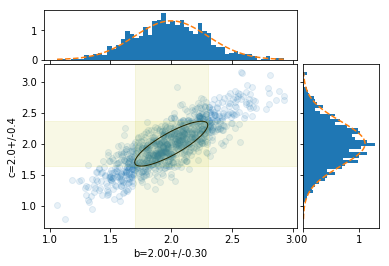

In [7]:
%pylab inline --no-import-all
import uncertainties
from scipy.stats import norm

a = uncertainties.ufloat(1.0, 0.1)
b = uncertainties.ufloat(2.0, 0.3)
c = a*b

mean = [b.n, c.n]
cov = uncertainties.covariance_matrix([b, c])

# Always use a fixed seed for reproducible data generation.
np.random.seed(1)
Nsamp = 1000
xs, ys = np.random.multivariate_normal(mean=mean, cov=cov, size=Nsamp).T
_x = np.linspace(xs.min(), xs.max(), 100)
_y = np.linspace(ys.min(), ys.max(), 100)

def plot_cov_ellipse(cov, mean, ax, points=100, fill=False, **kw):
    d, U = np.linalg.eigh(cov)
    thetas = 2*np.pi * np.arange(points)/points
    xs, ys = U.dot(np.exp(1j*thetas).view(dtype=float).reshape(points, 2).T
                   * np.sqrt(d)[:, None])
    path = matplotlib.path.Path(list(zip(xs+mean[0], ys+mean[1])), closed=True)
    ax.add_patch(matplotlib.patches.PathPatch(path, fill=fill, **kw))
    
# definitions for the axes
axis_sep = 0.04
hist_size = 0.3
gs = plt.GridSpec(2, 2, 
                  width_ratios=(1,hist_size), 
                  height_ratios=(hist_size,1),
                  wspace=axis_sep, hspace=axis_sep)

axScatter = plt.subplot(gs[1,0])
axHistx = plt.subplot(gs[0,0], sharex=axScatter)
axHisty = plt.subplot(gs[1,1], sharey=axScatter)

# no labels
axHistx.tick_params(labelbottom=False)
axHisty.tick_params(labelleft=False)

# the scatter plot:
axScatter.scatter(xs, ys, alpha=0.1)
axScatter.set_xlabel('b={}'.format(b))
axScatter.set_ylabel('c={}'.format(c))
plot_cov_ellipse(cov, ax=axScatter, mean=mean)

# demonstrate what ufloat errors are
axScatter.axvspan(b.n-b.s, b.n+b.s, color='y', alpha=0.1)
axScatter.axhspan(c.n-c.s, c.n+c.s, color='y', alpha=0.1)

# histograms
axHistx.hist(xs, bins=50, density=True)
axHistx.plot(_x, norm.pdf(_x, b.n, b.s), '--')
axHisty.hist(ys, bins=50, density=True, orientation='horizontal')
axHisty.plot(norm.pdf(_y, c.n, c.s), _y, '--');

# Example

Here we determine the period, phase, and amplitude of a sine wave using a least squares fit.  To simulate the errors, we provide Guassian samples of the errors.

Populating the interactive namespace from numpy and matplotlib


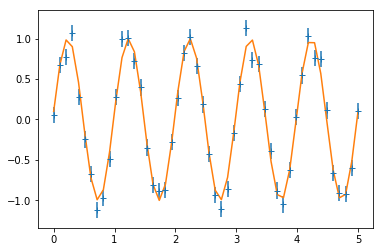

In [8]:
%pylab inline --no-import-all
import numpy as np
import uncertainties
from uncertainties import ufloat
from uncertainties import unumpy as unp

np.random.seed(2)  # Always use a seed so you can reproduce your results

def f(t, A, w, phi, np=np):
    return A*np.sin(w*t + phi)

A = 1.0
w = 2*np.pi
phi = 0.1

N = 50  # Sample size
ts = np.linspace(0, 5.0, N)
fs = f(ts, A, w, phi)
f_std_dev = 0.1  # Error in data
dfs = np.random.normal(0, f_std_dev, size=N)
plt.errorbar(ts, fs+dfs, f_std_dev, fmt='+')
plt.plot(ts, fs, '-');

In [9]:
from scipy.optimize import curve_fit

params_guess = (1.0, 2*np.pi, 1.0)
params, pcov = curve_fit(f, ts, fs + dfs, sigma=f_std_dev*np.ones(len(ts)), 
                         p0=params_guess, absolute_sigma=True)
                         
A_, w_, phi_ = uncertainties.correlated_values(
    params, covariance_mat=pcov, tags=['A', 'w', 'phi'])

print(A_, w_, phi_)
A__ = ufloat(A_.n, A_.s)
w__ = ufloat(w_.n, w_.s)
phi__ = ufloat(phi_.n, phi_.s)

1.009+/-0.020 6.269+/-0.013 0.13+/-0.04


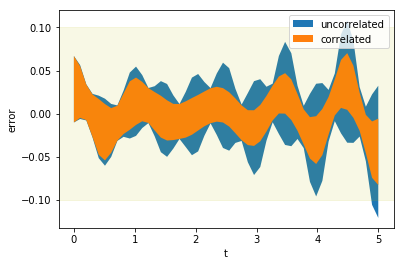

In [10]:
fs = f(ts, A, w, phi)
fs_ = f(ts, A_, w_, phi_, np=unp)
fs__ = f(ts, A__, w__, phi__, np=unp)
errs = unp.nominal_values(fs_ - fs)
plt.axhspan(-f_std_dev, f_std_dev, color='y', alpha=0.1)
plt.fill_between(ts, errs - unp.std_devs(fs__), errs + unp.std_devs(fs__), 
                label='uncorrelated', alpha=1.0)
plt.fill_between(ts, errs - unp.std_devs(fs_), errs + unp.std_devs(fs_), 
                label='correlated', alpha=1.0)
plt.ylabel('error')
plt.xlabel('t')
plt.legend(loc='best');

Above we demonstrate the difference between correlated and uncorrelated errors in the model parameters.

Here we use the Cholesky decomposition of the covariance matrix $\mat{C}$=`pcov` to [generate correlated random values](http://scipy-cookbook.readthedocs.io/items/CorrelatedRandomSamples.html) for the parameters.  We check with a histogram that these are indeed correctly generated:

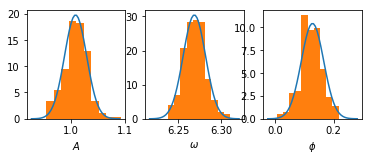

In [11]:
from scipy.stats import norm

M = 4
plt.figure(figsize=(6, 2))
C = np.linalg.cholesky(pcov)
labels = [r'$A$', r'$\omega$', r'$\phi$']
dA, dw, dphi = C.dot(np.random.normal(size=(3, N*M)))
for _n, (X, dX, label) in enumerate(
        zip([A_, w_, phi_],
            [dA, dw, dphi],
            labels)):
    _x = np.linspace(X.n-4*X.s, X.n + 4*X.s, 50)
    plt.subplot(131+_n)
    plt.plot(_x, norm.pdf(_x, X.n, X.s))
    plt.hist(X.n + dX, density=True)
    plt.xlabel(label)

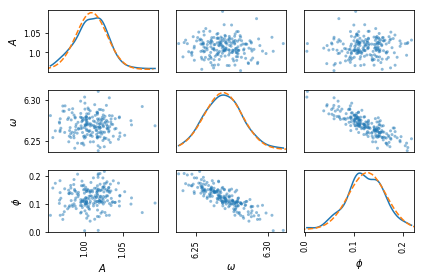

In [12]:
import pandas as pd
labels = [r'$A$', r'$\omega$', r'$\phi$']
data = np.transpose([A_.n + dA, w_.n + dw, phi_.n + dphi])
data_frame = pd.DataFrame(data, columns=labels)
scatter_axes = pd.plotting.scatter_matrix(data_frame, diagonal="kde")

plt.tight_layout()

for _n, (X, dX) in enumerate(
        zip([A_, w_, phi_],
            [dA, dw, dphi])):
    _x = np.linspace(X.n-4*X.s, X.n + 4*X.s, 50)
    scatter_axes[_n, _n].plot(_x, norm.pdf(_x, X.n, X.s), '--')
plt.savefig('Correlations.svg')

# To Do

As an exercise, use such randomly generated data to check that the parameter estimates are correct.